In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import datetime as dt
import geopandas as gpd
from shapely.geometry import Point, LineString,MultiLineString,Polygon
from shapely import ops
import matplotlib.pyplot as plt
%matplotlib inline
import os
import folium
attr='(c) <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors (c) <a href="http://cartodb.com/attributions">CartoDB</a>, CartoDB <a href ="http://cartodb.com/attributions">attributions</a>'
from selenium import webdriver
import PIL
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import glob
import moviepy.editor as mpy
from flask import request
import datetime
import glob

In [45]:
# # Define the API endpoint
# url = "https://data.traffic.hereapi.com/v7/flow"

# # Define the query parameters
# params = {
#     "locationReferencing": "shape",
#     #"in": "bbox:107.54908372065572,-6.926620456605005,107.72967148820469,-6.896286771555365",
#     "in": "bbox:107.2510292754,-7.3097642655,107.9384321719,-6.8128449268",
#     "apiKey": "z1hUE5rH83_F6uIgubqDkRHn6JQK8s5tUa106Nudp6c",
#     "responseattributes": "sh,fc"
# }


In [46]:
"https://traffic.api.here.com/traffic/6.3/flow.json?bbox=-6.926620456605005,107.54908372065572;-6.896286771555365,107.72967148820469&apiKey=Cdfx4rTgJqyfEJv1ydzReBDhwqpkx1PymIp4UjaYWvc&responseattributes=sh,fc"

'https://traffic.api.here.com/traffic/6.3/flow.json?bbox=-6.926620456605005,107.54908372065572;-6.896286771555365,107.72967148820469&apiKey=Cdfx4rTgJqyfEJv1ydzReBDhwqpkx1PymIp4UjaYWvc&responseattributes=sh,fc'

In [1]:
# # for renaming file into jakarta, asia time from utc time 
# import os
# import shutil
# import pytz
# from datetime import datetime

# def rename_json_files(directory_path, new_directory_path):
#     # Create the new directory if it doesn't exist
#     if not os.path.exists(new_directory_path):
#         os.makedirs(new_directory_path)

#     # Get a list of all JSON files in the directory
#     json_files = [f for f in os.listdir(directory_path) if f.endswith('.json')]

#     # Loop through each JSON file
#     for json_file in json_files:
#         # Extract the UTC time from the filename
#         utc_time_str = json_file.split('.')[0]
        
#         # Parse UTC time string to datetime object
#         utc_time = datetime.strptime(utc_time_str, '%Y-%m-%d %H-%M-%S')

#         # Convert UTC time to Jakarta time
#         jakarta_tz = pytz.timezone('Asia/Jakarta')
#         jakarta_time = utc_time.replace(tzinfo=pytz.utc).astimezone(jakarta_tz)

#         # Format Jakarta time to string for the new filename
#         jakarta_time_str = jakarta_time.strftime('%Y-%m-%d %H-%M-%S')
#         new_filename = jakarta_time_str + '.json'

#         # Copy the file to the new directory with the modified filename
#         shutil.copyfile(os.path.join(directory_path, json_file), os.path.join(new_directory_path, new_filename))

#     print('Renaming complete!')


In [2]:
# rename_json_files('E:\FASTRACK\SMT10\Bandung-Traffic\lebaran_tambahan','E:\FASTRACK\SMT10\Bandung-Traffic\lebaran_jkt_tambahan' )

Renaming complete!


In [2]:
## For delete json file that error in request
# import os
## Define the directory path
# directory_path = r'E:\FASTRACK\SMT10\Bandung-Traffic\json_'

# # Loop over all files in the directory
# for file_name in os.listdir(directory_path):
#     # Construct the full file path
#     file_path = os.path.join(directory_path, file_name)
    
#     # Check the content of the JSON file
#     with open(file_path, 'r') as f:
#         content = f.read()
#     if '"error": "Too Many Requests"' in content:
#         os.remove(file_path)
#         print(f'Removed {file_path} due to "Too Many Requests" error.')
#     else:
#         print(f'{file_path} is OK.')


In [2]:
# json to dataframe
import pandas as pd
import json

def dataframe(filename):
    with open(filename, 'r') as f:
        data = json.load(f)

    rows = []
    for result in data['results']:
        location = result['location']
        description = location.get('description', None) # use the .get() method to avoid KeyError
        length = location.get('length', None) 
        links = location['shape']['links']
        latitudes = []
        longitudes = []
        for link in links:
            if 'points' in link:
                for point in link['points']:
                    latitudes.append(point['lat'])
                    longitudes.append(point['lng'])
        currentFlow = result.get('currentFlow', {})
        speed = currentFlow.get('speed', None) 
        freeflow = currentFlow.get('freeFlow', None) 
        jamfactor = currentFlow.get('jamFactor', None) 
        rows.append([description, length, latitudes, longitudes, speed, freeflow, jamfactor])

    return pd.DataFrame(rows, columns=['Description', 'Length', 'Latitudes', 'Longitudes', 'Speed', 'FreeFlow', 'JamFactor'])


In [57]:
# df = dataframe('2023-03-28 20-19-22.json')

In [49]:
# df

,Description,Length,Latitudes,Longitudes,Speed,FreeFlow,JamFactor
0,Jalan Taman Singosari Ujung/Jalan Melong Asih,93.0,"[-6.918920008465648, -6.919689970090985]","[107.56337997503579, 107.56304997950792]",5.277778,5.277778,0.0
1,Jalan Jenderal Ahmad Yani,164.0,"[-6.901899967342615, -6.901920000091195, -6.90...","[107.65356003306806, 107.65380998142064, 107.6...",5.833334,8.333334,1.9
2,Jalan Cisaat,48.0,"[-6.941419970244169, -6.941130040213466, -6.94...","[107.53402998670936, 107.53412998281419, 107.5...",4.444445,4.444445,0.0
3,Jalan Sunda,49.0,"[-6.915920041501522, -6.915909983217716, -6.91...","[107.61835997924209, 107.61831002309918, 107.6...",6.666667,6.944445,0.4
4,Jalan Elang Raya,18.0,"[-6.915549980476499, -6.915609994903207]","[107.57482999004424, 107.574980026111]",3.888889,2.777778,0.0
...,...,...,...,...,...,...,...
2328,Jalan M. K. Wiganda Sasmita,58.0,"[-6.8698700331151485, -6.8703000247478485]","[107.54390001296997, 107.54360002465546]",4.722222,5.833334,0.3
2329,Jalan Terusan,170.0,"[-6.870059967041016, -6.870149988681078, -6.87...","[107.54414996132255, 107.54425004124641, 107.5...",5.277778,5.555556,0.3
2330,Jalan Terusan,367.0,"[-6.872619967907667, -6.8724300339818, -6.8724...","[107.54131997935474, 107.54137999378145, 107.5...",5.555556,6.388889,0.3
2331,Jalan Pojok Utara/Jalan Sisingamangaraja,268.0,"[-6.873030010610819, -6.872920040041208, -6.87...","[107.54118000157177, 107.5409800093621, 107.54...",7.222222,9.722222,1.5


In [50]:
##to make longlat into geodataframe format
# geometry = [LineString(list(zip(row['Longitudes'], row['Latitudes']))) for _, row in df.iterrows()]
# gdf = gpd.GeoDataFrame(df, geometry=geometry)
# gdf.crs = {'init':'epsg:4326'}


In [51]:
# gdf.head()

,Description,Length,Latitudes,Longitudes,Speed,FreeFlow,JamFactor,geometry
0,Jalan Taman Singosari Ujung/Jalan Melong Asih,93.0,"[-6.918920008465648, -6.919689970090985]","[107.56337997503579, 107.56304997950792]",5.277778,5.277778,0.0,"LINESTRING (107.56338 -6.91892, 107.56305 -6.9..."
1,Jalan Jenderal Ahmad Yani,164.0,"[-6.901899967342615, -6.901920000091195, -6.90...","[107.65356003306806, 107.65380998142064, 107.6...",5.833334,8.333334,1.9,"LINESTRING (107.65356 -6.90190, 107.65381 -6.9..."
2,Jalan Cisaat,48.0,"[-6.941419970244169, -6.941130040213466, -6.94...","[107.53402998670936, 107.53412998281419, 107.5...",4.444445,4.444445,0.0,"LINESTRING (107.53403 -6.94142, 107.53413 -6.9..."
3,Jalan Sunda,49.0,"[-6.915920041501522, -6.915909983217716, -6.91...","[107.61835997924209, 107.61831002309918, 107.6...",6.666667,6.944445,0.4,"LINESTRING (107.61836 -6.91592, 107.61831 -6.9..."
4,Jalan Elang Raya,18.0,"[-6.915549980476499, -6.915609994903207]","[107.57482999004424, 107.574980026111]",3.888889,2.777778,0.0,"LINESTRING (107.57483 -6.91555, 107.57498 -6.9..."


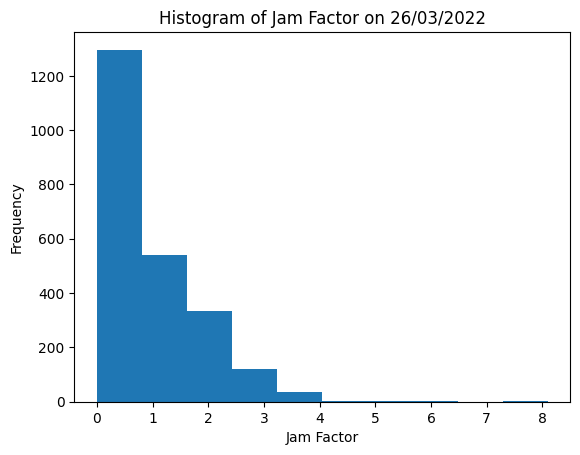

In [52]:
##to plot jam factor 
# import matplotlib.pyplot as plt

# # Create a histogram plot
# plt.hist(gdf['JamFactor'], bins=10)

# # Set the title and labels
# plt.title('Histogram of Jam Factor on 26/03/2022')
# plt.xlabel('Jam Factor')
# plt.ylabel('Frequency')

# # Show the plot
# plt.show()


In [58]:
# bin_edges = [-1, 1, 3, 4, 8, 11]

# # use pd.cut to categorize the 'jamFactor' column
# gdf['jamFactor_category'] = pd.cut(gdf['JamFactor'], bins=bin_edges)

# gdf['group'] = gdf['jamFactor_category']
# # print the count of observations in each category
# print(gdf['group'].value_counts())

NameError: name 'gdf' is not defined

<Axes: >

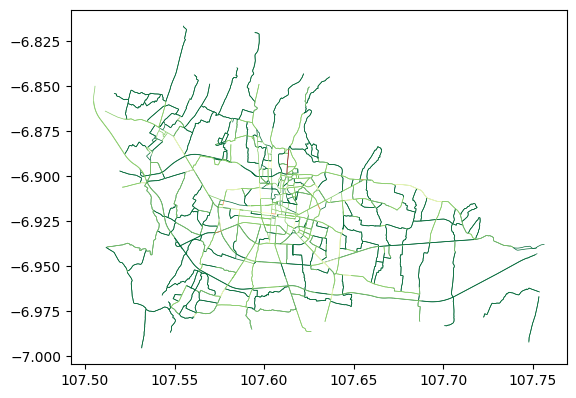

In [54]:
# gdf.sort_values("JamFactor").plot(column="group", cmap='RdYlGn_r', categorical=True, linewidth=.5)

In [55]:
# gdf['jamFactor_category']

0       (-1, 1]
1        (1, 3]
2       (-1, 1]
3       (-1, 1]
4       (-1, 1]
         ...   
2328    (-1, 1]
2329    (-1, 1]
2330    (-1, 1]
2331     (1, 3]
2332    (-1, 1]
Name: jamFactor_category, Length: 2333, dtype: category
Categories (5, interval[int64, right]): [(-1, 1] < (1, 3] < (3, 4] < (4, 8] < (8, 11]]

In [3]:
# To plot on map on folium 
def plot_lines_on_folium(gdf, fname, center_lat, center_lon, zoom_start):
    # convert JamFactor_category column to string
    #gdf['jamFactor_category'] = gdf['jamFactor_category'].astype(str)
    #gdf['rounded_speed'] = gdf['Speed'].round()
    gdf['group'] = gdf['group'].astype(str)
    
    # create map centered at specified latitude and longitude
    map_center = [center_lat, center_lon]
    m = folium.Map(location=map_center, zoom_start=zoom_start,tiles='CartoDB dark_matter')

    # Define the colors using RGB values
    color_dict = {
        '(-1, 1]': '#008000',
        '(1, 3]': '#7fff00',
        '(3, 4]': '#ffff00',
        '(4, 8]': '#ffa500',
        '(8, 11]': '#ff0000'
    }

    for idx, row in gdf.iterrows():
        color = None
        weight = None
        if row['group'] in color_dict:
            color = color_dict[row['group']]
            weight = 3
            #print (f"Row {idx} assigned color {color} and weight {weight}") #checking
        #else:
            #print(f"Row{idx} has invalid group {row['group']}") #checking 

        if color and weight:
            folium.features.PolyLine(locations=row['geometry'].coords, color=color, weight = weight).add_to(m)
            #print(f"Adding PolyLine with color {color}") #checking 
    
  

    # save map as HTML file
    m.save(f'{fname}')


In [4]:
# main function 
def process_here_maps_outputs(directory_path, output_dir):
    # Get a list of all JSON files in the directory
    json_files = glob.glob(os.path.join(directory_path, '*.json'))

    # Define empty DataFrame before the loop
    df = pd.DataFrame(columns=['Time', 'Date', 'Day', 'Description', 'Length', 'Latitudes', 'Longitudes', 'Speed', 'FreeFlow', 'JamFactor'])
    error_count = 0
    error_files = []

    for json_file in json_files:
        # Get the filename and parse the date and time
        filename = os.path.basename(json_file)
        date, time = os.path.splitext(filename)[0].split()
        year, month, day = date.split('-')
        hour, minute, second = time.split('-')
        
        # Get the day of the week as a string
        day_of_week = datetime.datetime(int(year), int(month), int(day)).strftime('%A')
        
        # Process each JSON file using the existing logic
        try: 
            df_temp = dataframe(json_file)
            print(f'{filename} ok dataframe')
        except:
            print(f'{filename} error dataframe')
            error_count += 1
            error_files.append(filename)
            continue
        
        # Add the date, time, and day columns to the DataFrame
        df_temp['Date'] = date
        df_temp['Time'] = time
        df_temp['Day'] = day_of_week
        
        # Append to the DataFrame after processing each file
        df = pd.concat([df, df_temp])
        if df is not None:
            geometry = [LineString(list(zip(row['Latitudes'], row['Longitudes']))) for _, row in df.iterrows()]
            gdf = gpd.GeoDataFrame(df, geometry=geometry)
            gdf.crs = {'init':'epsg:4326'} 
            bin_edges = [-1, 1, 3, 4, 8, 11]
            gdf['jamFactor_category'] = pd.cut(gdf['JamFactor'], bins=bin_edges)
            gdf['group'] = gdf['jamFactor_category']
            #gdf.sort_values("JamFactor").plot(column="group", cmap='RdYlGn_r', categorical=True, linewidth=.5)
            html_filename = os.path.splitext(os.path.basename(json_file))[0] + '.html'
            html_path = os.path.join(output_dir, html_filename)
            plot_lines_on_folium(gdf, html_path, -6.905977, 107.613144, 13)
    
    print(f'Total number of error files: {error_count}')  
    print("Files with errors:")
    print(error_files)
    return df

In [5]:
process_here_maps_outputs('E:\FASTRACK\SMT10\Bandung-Traffic\lebaran_00_tambahan_', 'E:\FASTRACK\SMT10\Bandung-Traffic\html_lebaran_tambahan')

2023-04-25 05-00-03.json ok dataframe
2023-04-25 06-00-03.json ok dataframe
2023-04-25 07-00-03.json ok dataframe
2023-04-25 08-00-03.json ok dataframe
2023-04-25 09-00-03.json ok dataframe
2023-04-25 10-00-02.json ok dataframe
2023-04-25 10-00-03.json ok dataframe
2023-04-25 11-00-03.json ok dataframe
2023-04-25 12-00-03.json ok dataframe
2023-04-25 13-00-03.json ok dataframe
2023-04-25 14-00-03.json ok dataframe
2023-04-25 15-00-03.json error dataframe
2023-04-25 16-00-03.json ok dataframe
2023-04-25 17-00-03.json ok dataframe
2023-04-25 18-00-03.json ok dataframe
2023-04-25 19-00-03.json ok dataframe
2023-04-25 20-00-03.json ok dataframe
2023-04-25 21-00-03.json ok dataframe
2023-04-25 22-00-02.json ok dataframe
2023-04-25 22-00-03.json ok dataframe
2023-04-25 23-00-03.json ok dataframe
2023-04-26 00-00-03.json ok dataframe
2023-04-26 01-00-03.json ok dataframe
2023-04-26 02-00-03.json ok dataframe
2023-04-26 03-00-03.json ok dataframe
2023-04-26 04-00-03.json ok dataframe
2023-04-2

,Time,Date,Day,Description,Length,Latitudes,Longitudes,Speed,FreeFlow,JamFactor,geometry,jamFactor_category,group
0,05-00-03,2023-04-25,Tuesday,Kabupaten Bandung 1,81.0,"[-6.978369997814298, -6.9780899584293365, -6.9...","[107.72266999818385, 107.72267997264862, 107.7...",5.277778,3.611111,0.0,"LINESTRING (-6.97837 107.72267, -6.97809 107.7...","(-1, 1]","(-1, 1]"
1,05-00-03,2023-04-25,Tuesday,Cangkuang Kulon,61.0,"[-6.974000008776784, -6.973760034888983, -6.97...","[107.59468998759985, 107.59474002756178, 107.5...",4.444445,4.444445,0.0,"LINESTRING (-6.97400 107.59469, -6.97376 107.5...","(-1, 1]","(-1, 1]"
2,05-00-03,2023-04-25,Tuesday,Cilisung/Citamiang,220.0,"[-6.974000008776784, -6.974149961024523, -6.97...","[107.59468998759985, 107.59474002756178, 107.5...",7.500000,7.777778,0.3,"LINESTRING (-6.97400 107.59469, -6.97415 107.5...","(-1, 1]","(-1, 1]"
3,05-00-03,2023-04-25,Tuesday,Jalan Geger Kalong Hilir,475.0,"[-6.873820004984736, -6.873529991135001, -6.87...","[107.59567997418344, 107.59543002583086, 107.5...",12.777778,8.888889,0.0,"LINESTRING (-6.87382 107.59568, -6.87353 107.5...","(-1, 1]","(-1, 1]"
4,05-00-03,2023-04-25,Tuesday,Jalan Cihanjuang,583.0,"[-6.875810036435723, -6.875629993155599, -6.87...","[107.55955003201962, 107.55929002538323, 107.5...",6.388889,6.666667,0.3,"LINESTRING (-6.87581 107.55955, -6.87563 107.5...","(-1, 1]","(-1, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,09-00-03,2023-04-27,Thursday,Jalan Anyelir I,669.0,"[-6.9363500084728, -6.937119970098138, -6.9371...","[107.70662996917963, 107.70661002025008, 107.7...",8.333334,13.888889,3.2,"LINESTRING (-6.93635 107.70663, -6.93712 107.7...","(3, 4]","(3, 4]"
2329,09-00-03,2023-04-27,Thursday,Jalan Raya Cipadung/Jalan A. H. Nasution,55.0,"[-6.931780027225614, -6.931710038334131, -6.93...","[107.71406002342701, 107.71409003064036, 107.7...",4.166667,4.166667,0.0,"LINESTRING (-6.93178 107.71406, -6.93171 107.7...","(-1, 1]","(-1, 1]"
2330,09-00-03,2023-04-27,Thursday,Jalan Dago Giri,1099.0,"[-6.859289975836873, -6.859219986945391, -6.85...","[107.62360998429358, 107.6236000098288, 107.62...",8.055555,8.333334,0.2,"LINESTRING (-6.85929 107.62361, -6.85922 107.6...","(-1, 1]","(-1, 1]"
2331,09-00-03,2023-04-27,Thursday,Jalan Maskumambang,126.0,"[-6.932779988273978, -6.932849977165461, -6.93...","[107.62616001069546, 107.6263699773699, 107.62...",5.555556,7.500000,1.4,"LINESTRING (-6.93278 107.62616, -6.93285 107.6...","(1, 3]","(1, 3]"


In [6]:
# export html files (folium map) to png 
import os
from selenium import webdriver
from time import sleep

def process_html_files(html_folder_path, screenshot_folder_path):
    # Get a list of all HTML files in the directory
    html_files = [f for f in os.listdir(html_folder_path) if f.endswith('.html')]

    for html_file in html_files:
        # Construct the file paths for the HTML and screenshot files
        html_file_path = os.path.join(html_folder_path, html_file)
        screenshot_file_path = os.path.join(screenshot_folder_path, os.path.splitext(html_file)[0] + ".png")

        # Open Chrome browser using Selenium web driver
        options = webdriver.ChromeOptions()
        options.add_argument('--ignore-certificate-errors')
        options.add_argument('--ignore-ssl-errors')
        driver = webdriver.Chrome(options=options)
        driver.get(os.path.abspath(html_file_path))

        # Wait for specified delay to ensure webpage has fully loaded
        sleep(5)

        # Maximize window and take screenshot
        driver.maximize_window()
        driver.save_screenshot(screenshot_file_path)

        # Close browser
        driver.quit()

        print(f"Screenshot saved as {screenshot_file_path}")

In [22]:
html_folder_path = 'E:\FASTRACK\SMT10\Bandung-Traffic\html_lebaran_sisa'
screenshot_folder_path = 'E:\FASTRACK\SMT10\Bandung-Traffic\png_lebaran'
process_html_files(html_folder_path, screenshot_folder_path)


Screenshot saved as E:\FASTRACK\SMT10\Bandung-Traffic\png_lebaran\2023-04-22 04-00-03.png
Screenshot saved as E:\FASTRACK\SMT10\Bandung-Traffic\png_lebaran\2023-04-22 05-00-02.png
Screenshot saved as E:\FASTRACK\SMT10\Bandung-Traffic\png_lebaran\2023-04-22 06-00-03.png
Screenshot saved as E:\FASTRACK\SMT10\Bandung-Traffic\png_lebaran\2023-04-22 07-00-03.png
Screenshot saved as E:\FASTRACK\SMT10\Bandung-Traffic\png_lebaran\2023-04-22 08-00-03.png
Screenshot saved as E:\FASTRACK\SMT10\Bandung-Traffic\png_lebaran\2023-04-22 09-00-03.png
Screenshot saved as E:\FASTRACK\SMT10\Bandung-Traffic\png_lebaran\2023-04-22 10-00-03.png
Screenshot saved as E:\FASTRACK\SMT10\Bandung-Traffic\png_lebaran\2023-04-22 11-00-02.png
Screenshot saved as E:\FASTRACK\SMT10\Bandung-Traffic\png_lebaran\2023-04-22 12-00-03.png
Screenshot saved as E:\FASTRACK\SMT10\Bandung-Traffic\png_lebaran\2023-04-22 14-00-03.png
Screenshot saved as E:\FASTRACK\SMT10\Bandung-Traffic\png_lebaran\2023-04-22 15-00-03.png
Screenshot

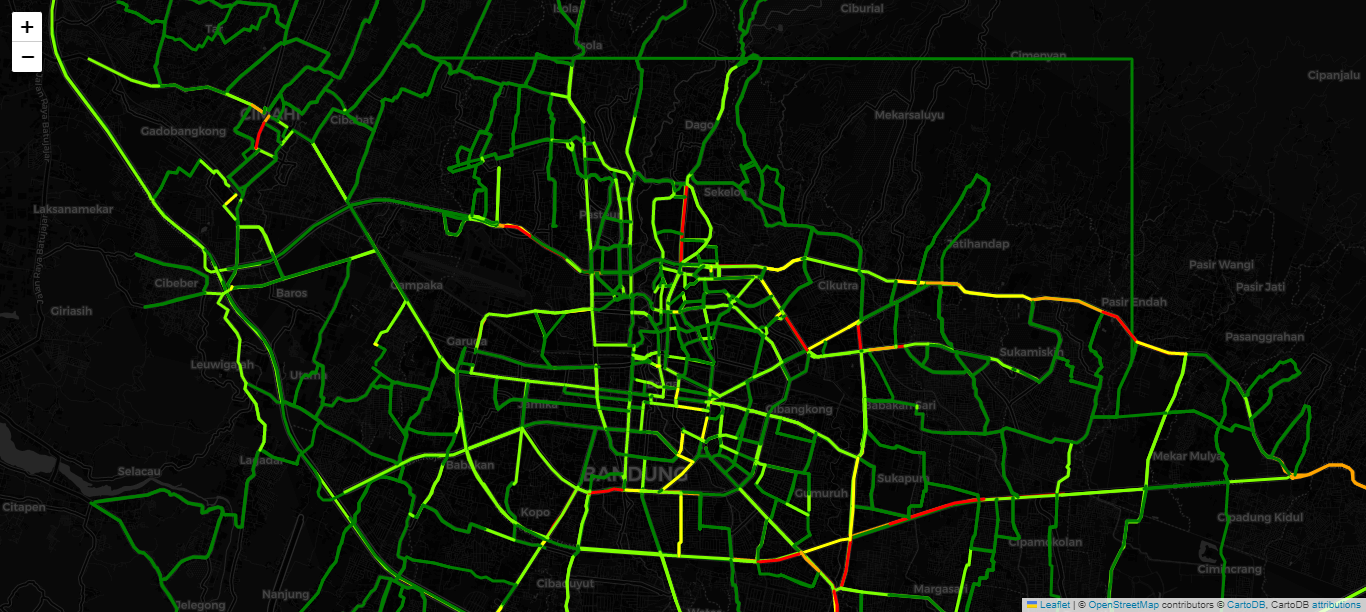

In [10]:
screenshot_folder_path = 'E:/FASTRACK/SMT10/Bandung-Traffic/png'
image = Image.open('2023-04-14 22-00-03.png')
image

In [23]:
import os
import datetime
from PIL import Image, ImageDraw, ImageFont

# path to the folder containing the images
folder_path = "E:/FASTRACK/SMT10/Bandung-Traffic/png_lebaran"

# path to the fonts
day_font_path = "E:/FASTRACK/SMT10/Bandung-Traffic/Montserrat-Regular.ttf"
date_font_path = "E:/FASTRACK/SMT10/Bandung-Traffic/Montserrat-ExtraBold.ttf"

# path to the folder where the captioned images will be saved
save_folder_path = "E:/FASTRACK/SMT10/Bandung-Traffic/caption_png_lebaran"

# dictionary mapping weekday number to the weekday name in Indonesian
daydict = {
    0: 'S E N I N',
    1: 'S E L A S A',
    2: 'R A B U',
    3: 'K A M I S',
    4: 'J U M A T', 
    5: 'S A B T U', 
    6: 'M I N G G U'
}

# iterate over all files in the folder
for filename in os.listdir(folder_path):
    # check if the file is a PNG image
    if filename.endswith(".png"):
        # parse the date and time information from the filename
        date_str, time_str = filename.split(".")[0].split()
        year, month, day = map(int, date_str.split("-"))
        hour, minute, second = map(int, time_str.split("-"))
        # create a datetime object from the parsed information
        dt_obj = datetime.datetime(year, month, day, hour, minute, second)
        # open the image file
        img = Image.open(os.path.join(folder_path, filename))
        # create a draw object
        draw = ImageDraw.Draw(img)
        # add the day caption
        font2 = ImageFont.truetype(day_font_path, size=35)
        day_caption = daydict[dt_obj.weekday()]
        day_caption_width, _ = draw.textsize(day_caption, font=font2)
        draw.text((30, img.height - 120), day_caption, fill='white', font=font2)
        # add the date caption
        font3 = ImageFont.truetype(date_font_path, size=20)
        date_caption = dt_obj.strftime("%d %B %Y")
        date_caption_width, _ = draw.textsize(date_caption, font=font3)
        draw.text((30, img.height - 80), date_caption, fill='grey', font=font3)
        # add the time caption
        font1 = ImageFont.truetype(date_font_path, size=50)
        time_caption = dt_obj.strftime("%H:%M")
        time_caption_width, _ = draw.textsize(time_caption, font=font1)
        draw.text((30, img.height - 180), time_caption, fill='white', font=font1)
        # save the captioned image to the new folder
        img.save(os.path.join(save_folder_path, filename))


In [24]:
import os
from PIL import Image

# path to the folder containing the PNG images
folder_path = "E:/FASTRACK/SMT10/Bandung-Traffic/caption_png_lebaran"

# path to the folder where the GIF animation will be saved
save_folder_path = "E:/FASTRACK/SMT10/Bandung-Traffic"

# list all the PNG files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]

# sort the list of files by filename, which contains the date and time information
image_files.sort()

# create a list of image objects from the PNG files
images = []
for filename in image_files:
    img = Image.open(os.path.join(folder_path, filename))
    images.append(img)

# save the list of images as an animated GIF file
save_path = os.path.join(save_folder_path, 'lebaran.gif')
images[0].save(save_path, save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)


In [25]:
import os
import imageio

# path to the folder containing the GIF file
folder_path = "E:/FASTRACK/SMT10/Bandung-Traffic"

# path to the output video file
output_path = os.path.join(folder_path, "lebaran.mp4")

# path to the GIF file
gif_path = os.path.join(folder_path, "lebaran.gif")

# read the GIF file and store its frames in a list
with imageio.get_reader(gif_path) as reader:
    frames = [frame for frame in reader]

# set the frame rate and speed of the video
frame_rate = 30
speed = 0.1

# create a writer object to save the video
with imageio.get_writer(output_path, fps=frame_rate * speed) as writer:
    # iterate over each frame and add it to the video writer
    for frame in frames:
        writer.append_data(frame)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1366, 612) to (1376, 624) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
